# Chapter 2 - housing project front to back

Here is my own version of the code as I walk through the chapter.

first step is to load in the data from

In [1]:
#imports for preprocess
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedShuffleSplit
import gc

#imports for ml training and predicting
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


#for gridsearch
from sklearn.model_selection import GridSearchCV

#for random hypterparam search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


#for inline graphing in a jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv('./supplemental/datasets/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


After loading the data, always have a look at it!

In [3]:
housing.info()
#note the missing data in total_bedrooms
#all numerical except for ocean proximity

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
#describe only returns the numerical arrtibutes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
#use value counts to look at an individual columns with categoricals
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Visually inspect the data
Note the use of the magic command %matplotlib inline below. This reders the histograms inside the jupyter notebook. The code line is useless in a regular script. plt.show() is optional for inline plotting as well!

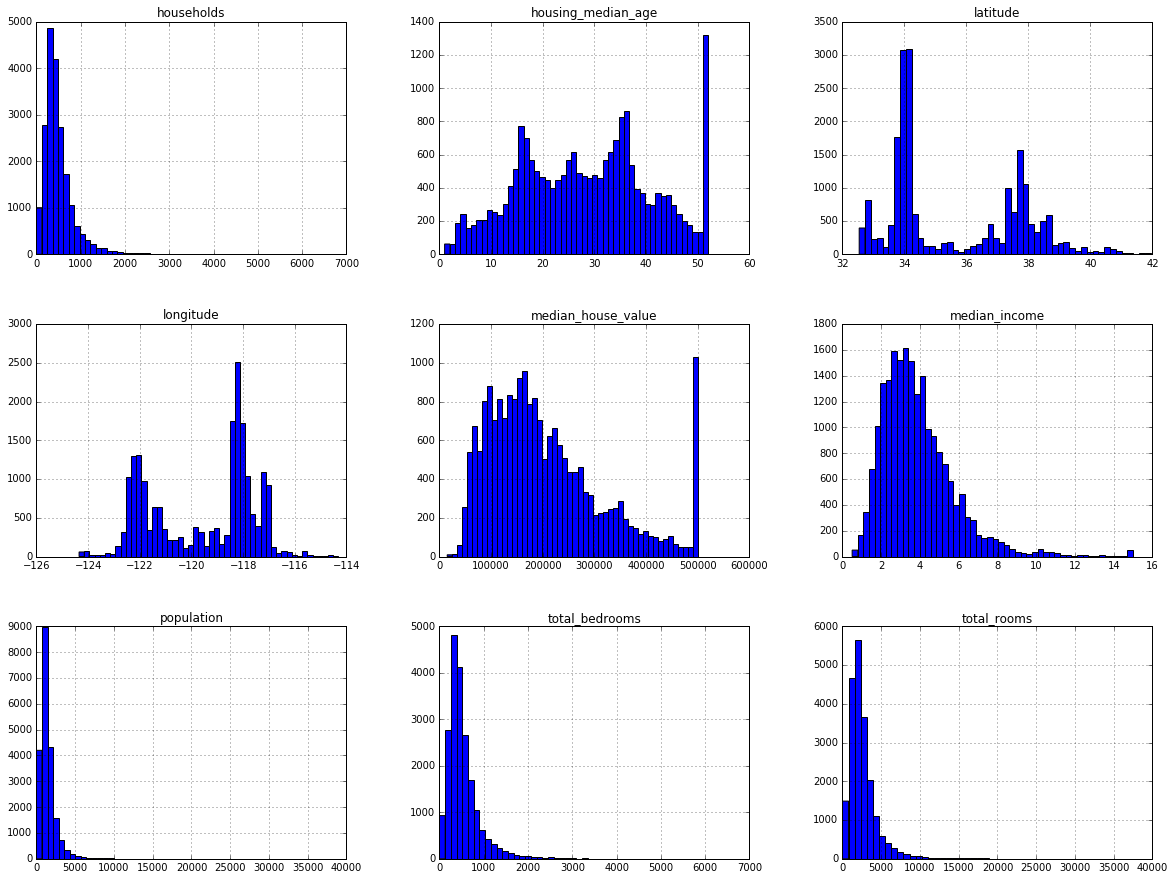

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

Note the cap on house value in the above graph. This poses a problem as it means the median values aren't being accurately recorded beyond the limit of $500,000. This limits the range over which our model can make accurate predictions.

# Create a test set of data
We pull this subsection from the main dataframe and put it to the side to not be looked at prior to testing out models. Don't look at it, as snooping the test data introduces a bias to your models and work!

Things to consider:
1. We want the same data to always be in the test set, not different data each time we run the script np.random.seed(12)
2. As we add new data to the dataset, we want the same values to stay in the test set as on previous runs

Fancy way on page 50 is to go off the last byte in the has of the ID column(seems a little overkill). In the past I've used a random number generator to add a column of the proper length. This doesn't deal with consideration #2 though.


### Use Scikit-Learn for train-test split
- has a random state paramater that allows you to set the random generator seed and keep the split consistent across multiple runs. Can pass in multiple datasets with the same numbers of rows and it will split them at the same time!

Scikit method:
-train_test_split import at start of notebook

In [7]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

In [8]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [9]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [10]:
#sanity check to make sure all rows accounted for.
len(test_set['longitude']) + len(train_set['longitude']) == len(housing['longitude'])

True

Split worked, note the jumbled indexes on the dataframes above

## Ensuring a representitive test set

If you have a particular variable that is important and you do not wish to produce a skewed test set. You can use the stratified sampling method below. First make a categorical variable that can be sampled on, and the the function will ensure an 80-20 split of data is taken from each category. This is not random, but instead makes sure you're training and test are both representitve of the population as a whole.

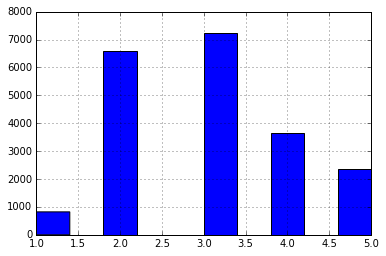

In [11]:

# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
#look a the categories
housing["income_cat"].hist()

#import the StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
#make a stratified split of the data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

below we can see that the purely random method produces a test set with skew to it, so we would not be accurately assessing the models.

In [12]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [13]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [14]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [15]:
len(strat_test_set['longitude']) + len(strat_train_set['longitude']) == len(housing['longitude'])

True

In [16]:
#change the names so you can work with just train and test set

test_set = strat_test_set
train_set = strat_train_set

gc.collect()

7192

# Explore and visualize data for initial insights

### scatterplot of the latitude and longitude

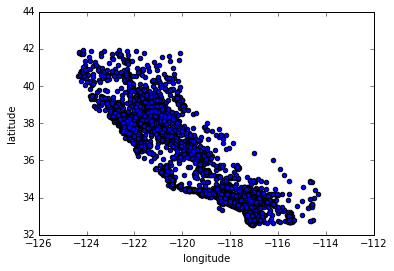

In [17]:
#result resembles an outline of california!
train_set.plot(kind = 'scatter', x='longitude', y='latitude')

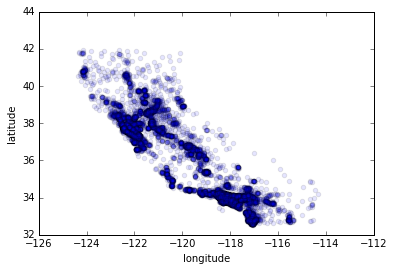

In [18]:
#the aplha adds transparency so we can see the high density areas better.
train_set.plot(kind = 'scatter', x='longitude', y='latitude', alpha=0.1)

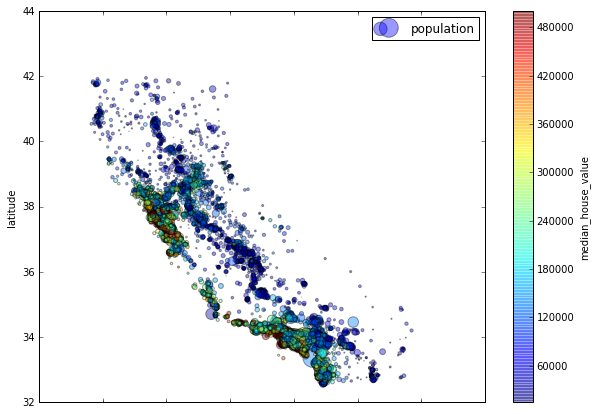

In [19]:
#below extends the scatterplot, it changes the circle size based on the population of the district
#and it changes the colour based on the median housing cost(low = blue, high = red)
train_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
              s=train_set['population']/100, label='population', figsize=(10,7),
              c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend() 

## Finding correlations in the data

With a small number of predictors like we have here (10) we can compute the piarwise pearson's correlation coefficients using the corr() method.

Note that the corr() method only detects linear relationships, and there may in fact be more complex relationships between the variables.

Scatter matrix function of pandas gives all the pairwise data comparisons (same as the pairs() function in R).




In [20]:
corr_matrix = train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending = False) #this finds the correlations with housing value
# ?pd.DataFrame.corr()
#value close to one is a strong positive correlation
#value close to -1 is strong negative correlation

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112c4c4a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112ffd4a8>]], dtype=object)

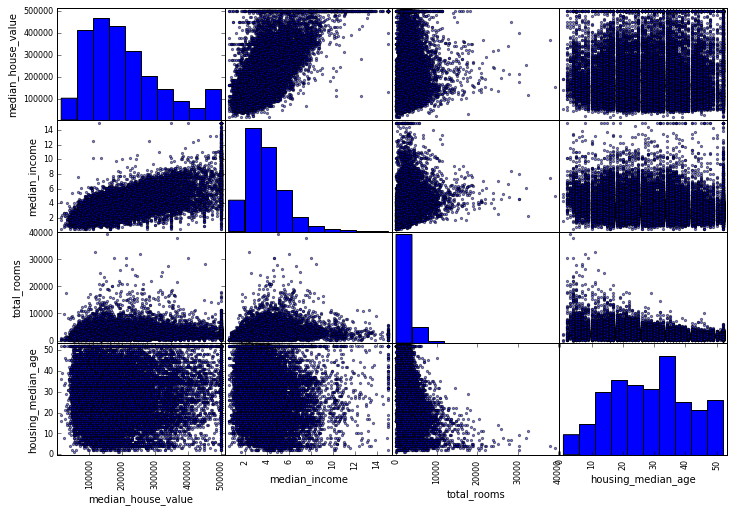

In [21]:
from pandas.tools.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12,8))
#note the diagonal boxes are the histograms of each of the attributes, as plotting the data to look for a correlation
#with itself would be pretty useless.


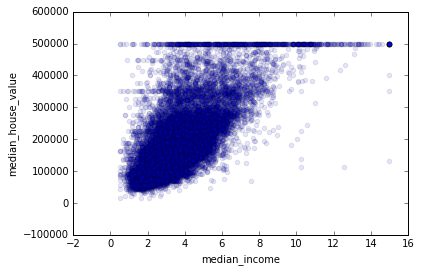

In [22]:
#from the above, the median income/ median_house_value is fairly strong
#this looks just at that plot
#from the below we can see that the $500,000 celing on the price is as issue, 
#seriously messes with the distribution cloud.
train_set.plot(kind = 'scatter', x= 'median_income', y='median_house_value', alpha=0.1)

## Munging the data

There are certain aspects of our dataset that arent especially informative, but we can make them so through basic transformation.

In [23]:
train_set.head()
# total rooms --> rooms_per_household
# total bedrooms --> bedrooms per household

def housing_data_clean(input_df):
    input_df['rooms_per_household'] = input_df['total_rooms']/input_df['households']
    input_df['bedrooms_per_household'] = input_df['total_bedrooms']/input_df['households']
    input_df['bedrooms_per_room'] = input_df['total_bedrooms']/input_df['total_rooms']
    input_df['population_per_household'] = input_df['population']/input_df['households']
    #input_df = input_df.drop(['total_bedrooms','total_rooms'], axis=1)
    return input_df

train_set = housing_data_clean(train_set)
train_set.head()
#do the same to the test set at the same time so they remain consistent with one another!
test_set = housing_data_clean(test_set)


In [24]:
corr_matrix = train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending = False) 

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
bedrooms_per_household     -0.043343
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Preparing data for machine learning algorithms

Best to use functions for this, it makes the process easily repeatiable and you can use the same function on the train and test data without needing to look at the test data.

Gradually you can build a library of repurpoable data munging functions.

In [25]:
X_train = train_set.drop('median_house_value', axis=1)
y_train = train_set['median_house_value'].values.astype(float)

X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].values.astype(float)


In [26]:
def fill_median(dataframe, cols):
    """impute the mean for a list of columns in the dataframe"""
    for i in cols:
        dataframe[i].fillna(dataframe[i].median(skipna=True), inplace = True)
    return dataframe

def cols_with_missing_values(dataframe):
    """ query a dataframe and find the columns that have missing values"""
    return list(dataframe.columns[dataframe.isnull().any()])

def fill_value(dataframe, col, val):
    """impute the value for a list column in the dataframe"""
    """ use this to impute the median of the train into the test"""
    dataframe[i].fillna(val, inplace = True)
    return dataframe


missing_vals = cols_with_missing_values(X_train)
X_train = fill_median(X_train,missing_vals)

In [27]:
print(missing_vals) #see which were missing in the train set
for i in missing_vals:
    X_test = fill_value(X_test, i, X_train[i].median(skipna=True))


['total_bedrooms', 'bedrooms_per_household', 'bedrooms_per_room']


## Working with categorical values
Most machine learning algorithms with need labels converted to numbers

Scikit-Learn has a transformer that turns categoricals into a ML friendly numerical fmt. It is LabelEncoder

In [28]:
#here we turn the ocean_proximity categorical into ml labels
encoder = LabelEncoder()
#below I went slightly off script from the example
housing_cat = X_train['ocean_proximity']
housing_cat_encoded = encoder.fit(housing_cat)
encoded_ocean_train = housing_cat_encoded.transform(list(housing_cat.values))
encoded_ocean_test = housing_cat_encoded.transform(list(X_test['ocean_proximity'].values))


In [29]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


the above is not perfect as it will assume a relationship between the values (i.e. 1 is more similar to 2 than to 4, when in fact this is not the case). To solve this we need to make some boolean dummies.

Boolean dummies also called 'one-hot' encoding. as in 1 is a hot(yes) and 0 is a cold (no)

In [30]:
encoder = OneHotEncoder()
encoded_ocean_train_1hot = encoder.fit_transform(encoded_ocean_train.reshape(-1,1))
encoded_ocean_train_1hot
encoded_ocean_test_1hot = encoder.transform(encoded_ocean_test.reshape(-1,1))

In [31]:
encoded_ocean_train_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [32]:
encoded_ocean_test_1hot

<4128x5 sparse matrix of type '<class 'numpy.float64'>'
	with 4128 stored elements in Compressed Sparse Row format>

The above outputs are SciPy sparse matricies, not numpy arrays. This is more memory efficient than a full numpy matrix for large numbers of categoricals, as it stores only presence (1s) not the thousands of zeros.

### combine the above into one step

the LabelBinarizer method lets us combine the to numbers and the one hot encoding into a single step.

In [33]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()

encoded_ocean_train_1hot = encoder.fit_transform(X_train['ocean_proximity'])
#I'm using just transform below to ensure that the categories are sorted and used the same as in the train fit.
encoded_ocean_test_1hot = encoder.transform(X_test['ocean_proximity'])



In [34]:
encoded_ocean_train_1hot #this returns a dense numpy array, pass in sparse_output=True to get the SciPy variant

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

The out of box methods from scikit learn are great, but you will need to customize the data munging at times.
Using class inheritence, these are easy to build on your own! see page 65 if you need to do this. example below.

The more of these munging steps you can automate, the easier it is to try different variants and experiment with tweaks to workflows.


In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling

If the input numerical attributes have very different scales, then the machine learning algorithms don't tend to perform well. i.e. if one has a range of 0-15 and another of 0-10000 then

## Transformation piplines

The large number of scikit learn methods for transforming, imputing etc can be combined using the pipeline function.
The only consideration is that all used frunctions must have a fit_transform() method.

Below we impute and scale the data using a custom pipeline:

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

NameError: name 'housing_num' is not defined

custom functions can also be used to make scikit learn act on a pandas dataframe directly without the conversion to a numpy array. example below:

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Textbook example of a built pipeline for cleaning the data

This is a consilidated set of functions that perform the tasks from above in a condensed manner, do it the way you're comfortable though, a lot of this is pretty abstracted so best to go through it yourself.

There is a large amount of imports used here. it is essentially just splitting the categoricals and numericals, imputing the median for the numericals, creating the new columns based on the bedrooms per house etc and then doing one hot encoding for the categoricals and adding them to the main df.

### benefits
- code the munging once and apply it for both the train and test dataframes using the same functions.
- deal with the categorical and numerical values separately before combining them back into a single output array
- pass in a dataframe and recieve a numpy array for model input without me having to worry about the in between steps each time

Note that the book saved the transformation of the test set to the very end, but I have here moved to to directly follow the test set transformation. This is so I can check that they are transformed at the same time. Both were built using the stratified train test split and then renamed to train_set and test_set prior to being split into the X and Y values

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer


#list the numeric and then list the categoricals
num_attribs = list(X_train.drop("ocean_proximity",axis=1).columns)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

In [40]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [41]:
housing_prepared = full_pipeline.fit_transform(X_train)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [42]:
housing_prepared.shape

(16512, 20)

In [43]:
#clean the test data in the same way

X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared.shape

(4128, 20)

## Variable review

In [44]:
X_test_prepared #the test x values
y_test #the actual y values
housing_prepared # the x train values
y_train #the y_train values

array([ 286600.,  340600.,  196900., ...,   97800.,  225900.,  500001.])

### with our data now manipulated into a format that is usable by the Scikit learn ml functions, we move on to training models

# Select and train a model

With our data now in the correct format, we just need to import the proper model with sklearn and then .fit() and .predict() for an initial run prior to optimization

## Linear regression

In [45]:
from sklearn.linear_model import LinearRegression

#initiate the instance
lin_reg = LinearRegression()

#fit the model with the train_x and train_y
lin_reg.fit(housing_prepared , y_train)



/Users/Cam/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

to make an initial assessment of efficacy, have a look at the root mean squared error on the training data itself

In [46]:
from sklearn.metrics import mean_squared_error

#predict on the training data
housing_predictions = lin_reg.predict(housing_prepared)
#pass y first, then yhat
linear_reg_mse = mean_squared_error(y_train , housing_predictions)
linear_reg_rmse = np.sqrt(linear_reg_mse)
linear_reg_rmse

68069.380086547841

The above value indicates that the predictions are still off by an average of $68,000 which isn't very close since most data fall between $120,000 and $265,000. The linear regression model is therefore a definite underfit.

In this case we likely need a more powerful model to explain the data. Next up, a decision tree regression

In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [48]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(y_train, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

This gives a RMSE of 0.0. which is a good red flag of overfit. 
To test this we can don't want to immediately test on the test data, we should first do internal cross validation on the training data, to seek if the model is overfit or in fact a good predictor.

## Evalution of models using cross validation



In [49]:
from sklearn.model_selection import cross_val_score

#pass in the model, the train_x and the train_y. along with the k-fold # and the scoring param to be used
scores = cross_val_score(tree_reg, housing_prepared, y_train, 
                         scoring='neg_mean_squared_error', cv = 10 )

tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores #the output gives all 10 cross validation scores

array([ 72232.89204048,  68486.15833921,  71311.33405218,  72378.92405782,
        70275.97016306,  74991.72815788,  71762.93738915,  70310.93167716,
        74922.23043835,  71615.19108219])

below is a function to help intrepret the k-fold output

In [50]:
def display_scores(scores):
    """ pass in a cross_val_score output and 
        this returns the data in formatted manner """
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('std_dev:', scores.std())
    

In [51]:
display_scores(tree_rmse_scores)

Scores: [ 72232.89204048  68486.15833921  71311.33405218  72378.92405782
  70275.97016306  74991.72815788  71762.93738915  70310.93167716
  74922.23043835  71615.19108219]
Mean: 71828.8297397
std_dev: 1903.82638224


In [52]:
scores = cross_val_score(lin_reg, housing_prepared, y_train, 
                         scoring='neg_mean_squared_error', cv = 10 )

lin_reg_rmse_scores = np.sqrt(-scores)
display_scores(lin_reg_rmse_scores)

Scores: [ 66058.49471448  66683.94071268  67733.63150855  74774.19283931
  67610.21143668  70813.80272677  64026.36935014  68064.20495722
  70600.68192128  67254.2645684 ]
Mean: 68361.9794736
std_dev: 2851.92488932


Above we see that the linear regression actually out performed the decision trees, which were over fitting the model. This would not have been evident without the cross validation step.


## Compare random forest to the decision tree and linear regression

In [59]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, y_train)

#test on itself, is it overfitting the training set?
forest_self = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(y_train,forest_self)

scores = cross_val_score(forest_reg, housing_prepared, y_train, 
                         scoring='neg_mean_squared_error', cv = 10 )


forest_rmse = np.sqrt(-scores)

In [60]:
forest_mse
display_scores(forest_rmse)

Scores: [ 53955.19038152  50779.35704182  53243.03008217  55665.10639149
  52516.06047835  55891.08525665  52318.74824262  51053.79671942
  55406.29245969  52984.38356532]
Mean: 53381.3050619
std_dev: 1737.42435438


Note how much lower the mean rmse is for the random forest, predictions are about $10,000 closer than with the linear regression.

## Tuning the model
### grid search cross validation
Go through numerous pairwise comparisons of hyperparamaters and find the optimal set to use in the model.


In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

#set the random state to ensure results are consistent.
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
#if below passed refit = True, it would train the model with all the data once the optimal
#paramater set was found.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

#fit the grid search with the training data
grid_search.fit(housing_prepared, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

with the grid search cv run, the following let you observe the optimal paramater combinations

In [62]:
#get the top tuned hyperparamaters
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [63]:
#which model was the best estimator?
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
#what were the scores for the different paramater combinations.
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
#long form version to see the cv results all laid out.
pd.DataFrame(grid_search.cv_results_)

If your number of hyperparamaters is large, then using gridsearchCV will take too long.
RandomizedSearchCV will sample a subsample of the hyperparam combos to keep things efficient.

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112be0dd8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112be0940>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

looking at feature importance can help you refine the model by trimming the predictors that introduce error

In [65]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  5.62691233e-02,   5.32054323e-02,   4.01576088e-02,
         1.28819085e-02,   1.20620976e-02,   1.38230818e-02,
         1.22970261e-02,   3.45918626e-01,   3.31001017e-02,
         1.97635430e-02,   2.44661655e-02,   6.45427140e-02,
         3.13282243e-02,   6.10910923e-02,   5.23313000e-02,
         6.98960215e-03,   1.54036010e-01,   3.48972589e-05,
         2.15079248e-03,   3.55065314e-03])

In [66]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34591862598004197, 'median_income'),
 (0.15403600972767523, 'INLAND'),
 (0.064542714004196575, 'population_per_household'),
 (0.061091092313581855, 'pop_per_hhold'),
 (0.056269123338670332, 'longitude'),
 (0.05320543226972866, 'latitude'),
 (0.052331300033180789, 'bedrooms_per_room'),
 (0.040157608834027615, 'housing_median_age'),
 (0.033100101665173874, 'rooms_per_household'),
 (0.031328224306577383, 'rooms_per_hhold'),
 (0.024466165470774785, 'bedrooms_per_room'),
 (0.019763543017294813, 'bedrooms_per_household'),
 (0.013823081844277418, 'population'),
 (0.012881908491882418, 'total_rooms'),
 (0.012297026096285585, 'households'),
 (0.012062097574089818, 'total_bedrooms'),
 (0.0069896021461753341, '<1H OCEAN'),
 (0.003550653144562944, 'NEAR OCEAN'),
 (0.0021507924829405017, 'NEAR BAY'),
 (3.4897258862177233e-05, 'ISLAND')]

In [67]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

with the final model picked (through rf gridCV) we can evalute on the test set. Recall our X_test is already prepared above.

In [69]:
final_model = grid_search.best_estimator_


final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49227.921202720099

The final model scores off by an average of $49,000 on the test data, a great improvement from our initial models!